In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from collections import Counter
from nltk.tokenize import word_tokenize
import nltk
from nltk.tokenize import RegexpTokenizer
from collections import Counter
from tabulate import tabulate
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

## Scrapping of Data

In [2]:
def scrape_reviews(drug_name):
    url = 'https://www.drugs.com' + drug_name
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    reviews = []
    review_elements = soup.find_all('div', class_='ddc-comment ddc-box ddc-mgb-2')

    for element in review_elements:
        comment = element.find('p').text.strip()
        
        reviews.append({
            'comment': comment
        })

    return reviews



In [3]:
def scrape_drug_info(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Find the section for popular drugs; you'll need to adjust the selector as per actual content structure
    popular_drugs_section = soup.find('ul', class_='ddc-list-column-4')
    drug_links = popular_drugs_section.find_all('a')
    
    drugs_info = []
    for link in drug_links:
        drug_url = 'https://www.drugs.com' + link.get('href')
        drug_page = requests.get(drug_url)
        drug_soup = BeautifulSoup(drug_page.text, 'html.parser')
        
        drug_name = drug_soup.find('h1').text.strip()
        uses = drug_soup.find('h2', id='uses')
        uses_texts = []
        for tag in uses.find_next_siblings():
            if tag.name != 'h2':
                uses_texts.append(tag.text.strip())
            else:
                break 
        side_effects = drug_soup.find('h2', id='side-effects')
        side_effects_text = []
        for tag in side_effects.find_next_siblings():
            if tag.name != 'h2':
                side_effects_text.append(tag.text.strip())
            else:
                break 
                
        review = drug_soup.find('div', class_='ddc-rating-summary')
        review_link = review.find('em')
        if not review_link == None:
            review_link_text = review_link.find('a')
            if review_link_text:
                review_data = scrape_reviews(review_link_text.get('href'))
            else:
                review_data = []
        else:
            review_data = []
                
        
        
        drugs_info.append({
            'drug_name': drug_name,
            'uses': uses_texts,
            'side_effects': side_effects_text,
            'reviews': review_data
        })
    return drugs_info

# Usage
url = 'https://www.drugs.com/drug_information.html'
results = scrape_drug_info(url)
df = pd.DataFrame(results)
print(df)
# print(results[0])

        drug_name                                               uses  \
0   Acetaminophen  [Acetaminophen is a pain reliever and a fever ...   
1        Adderall  [Adderall is used to treat attention deficit h...   
2   Amitriptyline  [Amitriptyline is a tricyclic antidepressant u...   
3      Amlodipine  [Amlodipine besylate belongs to a class of med...   
4     Amoxicillin  [Amoxicillin is a penicillin antibiotic used t...   
..            ...                                                ...   
67         Viagra  [Viagra relaxes muscles found in the walls of ...   
68         Wegovy  [Wegovy injection is used for weight loss and ...   
69     Wellbutrin  [Wellbutrin is an antidepressant medicine that...   
70          Xanax  [Xanax is a benzodiazepine (ben-zoe-dye-AZE-eh...   
71        Zubsolv  [Zubsolv sublingual tablets contain a combinat...   

                                         side_effects  \
0   [Get emergency medical help if you have signs ...   
1   [Get emergency me

## Exporting scraped data to CSV file

In [69]:
df.to_csv('data.csv')

## Reading CSV File

In [3]:

file_path = 'data.csv'
data = pd.read_csv(file_path)
print(data.head())


   Unnamed: 0      drug_name  \
0           0  Acetaminophen   
1           1       Adderall   
2           2  Amitriptyline   
3           3     Amlodipine   
4           4    Amoxicillin   

                                                uses  \
0  ['Acetaminophen is a pain reliever and a fever...   
1  ['Adderall is used to treat attention deficit ...   
2  ['Amitriptyline is a tricyclic antidepressant ...   
3  ['Amlodipine besylate belongs to a class of me...   
4  ['Amoxicillin is a penicillin antibiotic used ...   

                                        side_effects  \
0  ['Get emergency medical help if you have signs...   
1  ['Get emergency medical help if you have signs...   
2  ['Common amitriptyline side effects', 'Common ...   
3  ['Common amlodipine side effects', 'The most c...   
4  ['Common amoxicillin side effects', 'Common am...   

                                             reviews  
0  [{'comment': 'Tylenol (acetaminophen) for Pain...  
1  [{'comment': 'For AD

## Tokenization:

In [4]:

def extract_words(text):
    tokenizer = RegexpTokenizer(r'\w+')
    words = tokenizer.tokenize(text.lower())
    return words

all_words = data['uses'].apply(extract_words).sum() + \
            data['side_effects'].apply(extract_words).sum() + \
            data['reviews'].apply(eval).apply(lambda x: " ".join([d['comment'] for d in x])).apply(extract_words).sum()

word_freq = Counter(all_words)
word_freq.most_common(100)



[('i', 11298),
 ('and', 6808),
 ('the', 5926),
 ('to', 5483),
 ('for', 4796),
 ('a', 4514),
 ('my', 4017),
 ('it', 3898),
 ('of', 3375),
 ('was', 2540),
 ('have', 2398),
 ('in', 2292),
 ('this', 2086),
 ('is', 2015),
 ('on', 1916),
 ('that', 1710),
 ('me', 1696),
 ('with', 1685),
 ('or', 1547),
 ('but', 1436),
 ('had', 1418),
 ('you', 1415),
 ('pain', 1396),
 ('t', 1373),
 ('side', 1288),
 ('not', 1263),
 ('effects', 1197),
 ('so', 1125),
 ('been', 1001),
 ('at', 974),
 ('day', 950),
 ('as', 943),
 ('after', 870),
 ('taking', 869),
 ('if', 858),
 ('your', 845),
 ('no', 836),
 ('all', 810),
 ('n', 802),
 ('am', 767),
 ('2', 760),
 ('take', 749),
 ('m', 742),
 ('s', 736),
 ('be', 733),
 ('now', 730),
 ('years', 730),
 ('like', 726),
 ('can', 718),
 ('about', 713),
 ('has', 700),
 ('get', 666),
 ('up', 660),
 ('from', 655),
 ('are', 626),
 ('feel', 613),
 ('an', 607),
 ('life', 599),
 ('doctor', 590),
 ('ve', 577),
 ('days', 564),
 ('anxiety', 563),
 ('just', 563),
 ('medication', 562),
 

## Summarization

In [5]:

medical_terms = {
    'allergic', 'anxiety', 'bleeding', 'blood', 'cancer', 'clinical', 'diarrhea', 'disease', 'dizziness', 
    'fatigue', 'fever', 'headache', 'heart', 'infection', 'itching', 'kidney',
    'liver', 'medication', 'nausea', 'pain', 'prescription', 'pressure', 'rash', 'reaction', 'surgery', 
    'swelling', 'symptoms', 'therapy', 'treatment', 'vomiting'
}


def summarize_as_medical_keywords(text, medical_terms, num_keywords=5):
    words = word_tokenize(text.lower())
    filtered_words = [word for word in words if word in medical_terms]
    word_freq = Counter(filtered_words)
    most_common_terms = [word for word, freq in word_freq.most_common(num_keywords)]
    
    return ", ".join(most_common_terms)

data['drug_name'] = data['drug_name']
data['side_effects_summary'] = data['side_effects'].apply(lambda x: summarize_as_medical_keywords(x, medical_terms))
data['reviews_summary'] = data['reviews'].apply(lambda x: summarize_as_medical_keywords(x, medical_terms))

selected_columns = data[['drug_name', 'side_effects_summary', 'reviews_summary']].head()
print(tabulate(selected_columns, headers='keys', tablefmt='psql'))


+----+---------------+--------------------------------------------+---------------------------------------------------+
|    | drug_name     | side_effects_summary                       | reviews_summary                                   |
|----+---------------+--------------------------------------------+---------------------------------------------------|
|  0 | Acetaminophen | reaction, allergic, swelling, rash, liver  | pain, liver, fever, reaction, disease             |
|  1 | Adderall      | heart, pain, allergic, reaction, swelling  | prescription, medication, fatigue, anxiety, heart |
|  2 | Amitriptyline | pain, nausea, swelling, diarrhea, vomiting | anxiety, pain, medication, heart, symptoms        |
|  3 | Amlodipine    | pain, nausea, allergic, reaction, swelling | blood, pressure, anxiety, pain, medication        |
|  4 | Amoxicillin   | rash, reaction, pain, nausea, vomiting     | pain, infection, medication, pressure, blood      |
+----+---------------+------------------

## Modeling:

In [6]:

df = pd.DataFrame(data)

# Tokenizing and preparing text data
tokenizer = RegexpTokenizer(r'\w+')
df['processed_side_effects'] = df['side_effects_summary'].apply(lambda x: tokenizer.tokenize(x.lower()))
df['processed_reviews'] = df['reviews_summary'].apply(lambda x: tokenizer.tokenize(x.lower()))

# Creating dictionary and corpus for LDA
dictionary = corpora.Dictionary(df['processed_side_effects'] + df['processed_reviews'])
corpus_side_effects = [dictionary.doc2bow(text) for text in df['processed_side_effects']]
corpus_reviews = [dictionary.doc2bow(text) for text in df['processed_reviews']]

# LDA model
ldamodel = models.LdaModel(corpus_side_effects + corpus_reviews, num_topics=3, id2word=dictionary, passes=15)

# Identifying unique review topics
topics_side_effects = [ldamodel.get_document_topics(bow) for bow in corpus_side_effects]
topics_reviews = [ldamodel.get_document_topics(bow) for bow in corpus_reviews]

# Function to parse topics to string
def topics_to_string(topics):
    return ', '.join([f"Topic {topic[0]}: {topic[1]:.2f}" for topic in topics])

results = pd.DataFrame({
    'drug_name': df['drug_name'],
    'unique_side_effects_in_reviews': [topics_to_string(topics_reviews[i]) for i in range(len(df))],
    'topics_of_side_effects_in_summary': [topics_to_string(topics_side_effects[i]) for i in range(len(df))]
})

print(tabulate(results.head(), headers='keys', tablefmt='psql'))


+----+---------------+---------------------------------------------+---------------------------------------------+
|    | drug_name     | unique_side_effects_in_reviews              | topics_of_side_effects_in_summary           |
|----+---------------+---------------------------------------------+---------------------------------------------|
|  0 | Acetaminophen | Topic 0: 0.06, Topic 1: 0.25, Topic 2: 0.69 | Topic 0: 0.06, Topic 1: 0.06, Topic 2: 0.89 |
|  1 | Adderall      | Topic 0: 0.06, Topic 1: 0.89, Topic 2: 0.06 | Topic 0: 0.06, Topic 1: 0.06, Topic 2: 0.88 |
|  2 | Amitriptyline | Topic 0: 0.06, Topic 1: 0.88, Topic 2: 0.06 | Topic 0: 0.88, Topic 1: 0.06, Topic 2: 0.06 |
|  3 | Amlodipine    | Topic 0: 0.06, Topic 1: 0.88, Topic 2: 0.06 | Topic 0: 0.40, Topic 1: 0.06, Topic 2: 0.54 |
|  4 | Amoxicillin   | Topic 0: 0.06, Topic 1: 0.80, Topic 2: 0.15 | Topic 0: 0.52, Topic 1: 0.06, Topic 2: 0.42 |
+----+---------------+---------------------------------------------+------------

In [7]:



def get_dominant_topic(topic_list):
    if topic_list:
        return max(topic_list, key=lambda item: item[1])[0]  # Return the topic with the highest probability
    return None

df['dominant_topic_side_effects'] = [get_dominant_topic(ldamodel.get_document_topics(bow)) for bow in corpus_side_effects]
df['dominant_topic_reviews'] = [get_dominant_topic(ldamodel.get_document_topics(bow)) for bow in corpus_reviews]

results = pd.DataFrame({
    'drug_name': df['drug_name'],
    'dominant_topic_side_effects': df['dominant_topic_side_effects'],
    'dominant_topic_reviews': df['dominant_topic_reviews']
})

print(results)

        drug_name  dominant_topic_side_effects  dominant_topic_reviews
0   Acetaminophen                            2                       2
1        Adderall                            2                       1
2   Amitriptyline                            0                       1
3      Amlodipine                            2                       1
4     Amoxicillin                            0                       1
..            ...                          ...                     ...
67         Viagra                            2                       1
68         Wegovy                            0                       0
69     Wellbutrin                            2                       1
70          Xanax                            2                       1
71        Zubsolv                            0                       1

[72 rows x 3 columns]


In [8]:

num_words = 3  # Number of top words to display for each topic

for i in range(3):
    print(f"Topic {i}:")
    words = ldamodel.show_topic(i, topn=num_words)
    print(", ".join([word for word, prob in words]))


Topic 0:
nausea, vomiting, diarrhea
Topic 1:
medication, pain, anxiety
Topic 2:
pain, reaction, swelling


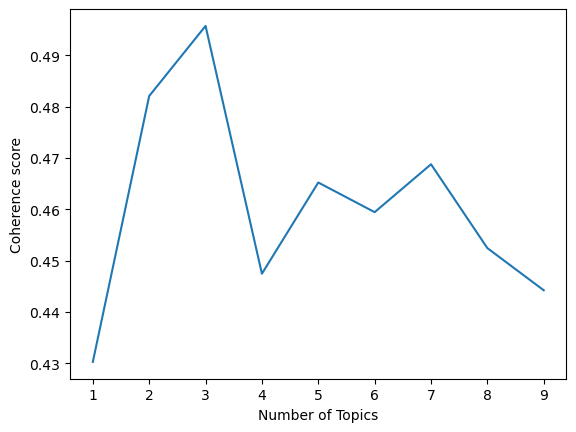

Optimal number of topics: 3


In [11]:

# Iterate over possible number of topics
topic_numbers = range(1, 10)
coherence_scores = []
for num_topics in topic_numbers:
    ldamodel = models.LdaModel(corpus_reviews, num_topics=num_topics, id2word=dictionary, passes=15)
    coherence_model_lda = CoherenceModel(model=ldamodel, texts=df['processed_reviews'], dictionary=dictionary, coherence='c_v')
    coherence_scores.append(coherence_model_lda.get_coherence())

import matplotlib.pyplot as plt
plt.plot(topic_numbers, coherence_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.show()

# Identify the number of topics with the highest coherence score
optimal_topics = topic_numbers[np.argmax(coherence_scores)]
print("Optimal number of topics:", optimal_topics)


In [15]:
#Training lda again for optimal_topics
ldamodel = models.LdaModel(corpus_reviews, num_topics=optimal_topics, id2word=dictionary, passes=15)

coherence_model_lda = CoherenceModel(model=ldamodel, texts=df['processed_reviews'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score:', coherence_lda)


Coherence Score: 0.4769490943256994


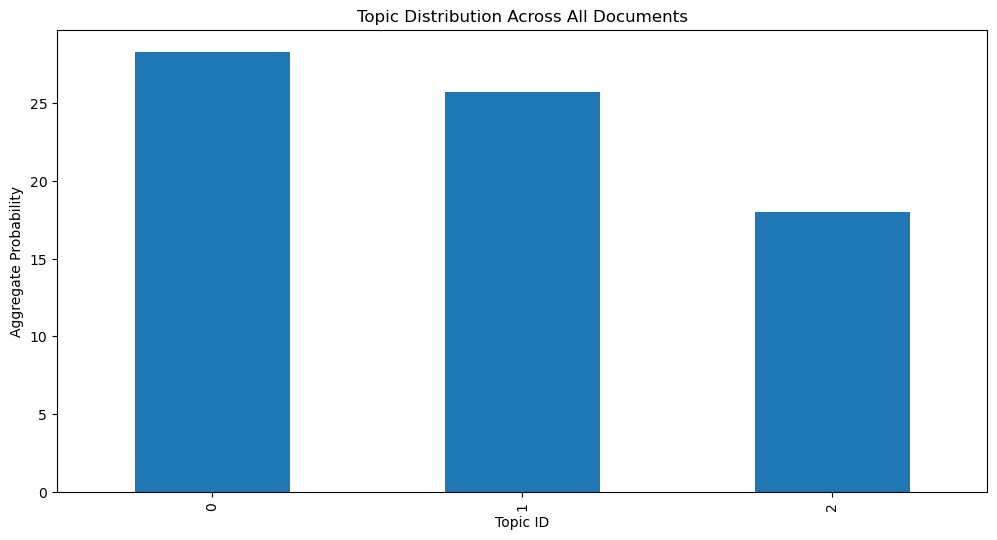

In [16]:

topic_distribution = [ldamodel.get_document_topics(bow) for bow in corpus_reviews]


topic_counts = pd.DataFrame([
    {topic_id: prob for topic_id, prob in doc}
    for doc in topic_distribution
]).fillna(0) 

# Sum topic counts to see overall prevalence
topic_sums = topic_counts.sum()


topic_sums.plot(kind='bar', figsize=(12, 6), title='Topic Distribution Across All Documents')
plt.xlabel('Topic ID')
plt.ylabel('Aggregate Probability')
plt.show()


## Heatmap

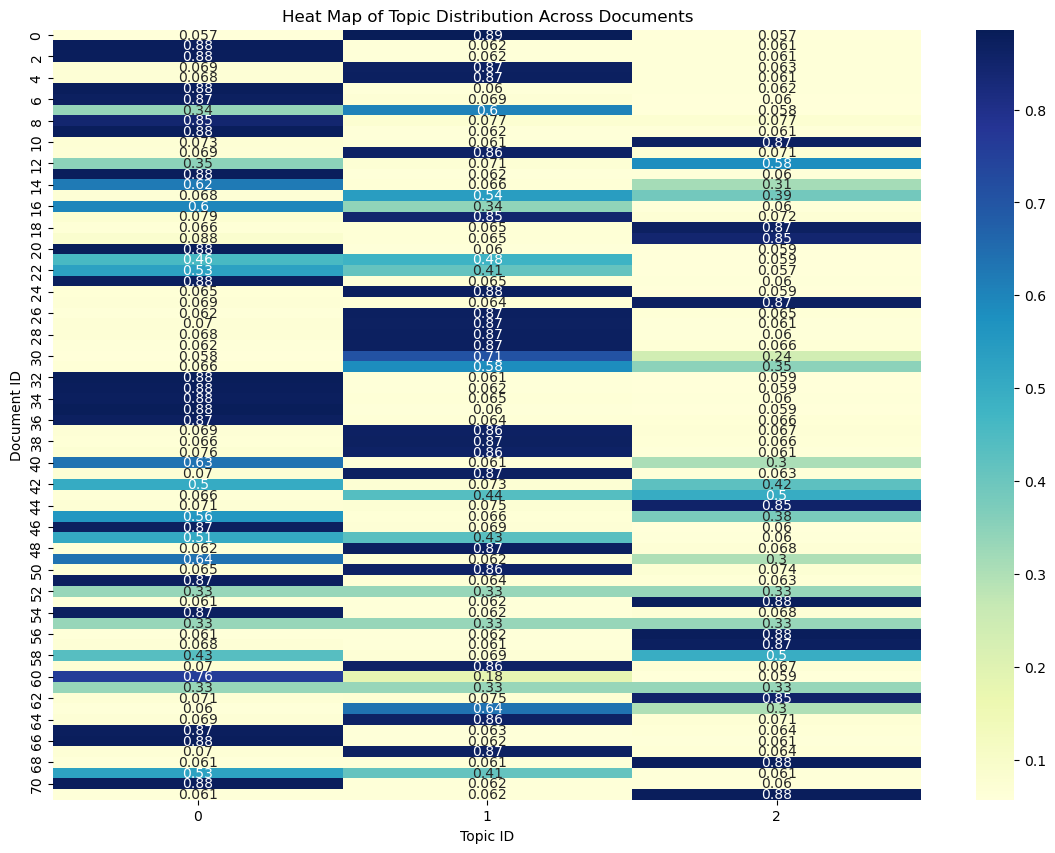

In [17]:

plt.figure(figsize=(14, 10))
sns.heatmap(topic_counts, annot=True, cmap='YlGnBu', cbar=True)
plt.title('Heat Map of Topic Distribution Across Documents')
plt.xlabel('Topic ID')
plt.ylabel('Document ID')
plt.show()


In [18]:

# Assuming df is your DataFrame
df.to_csv('osummary.csv', index=False)


## Exploratory Data Analysis (EDA)

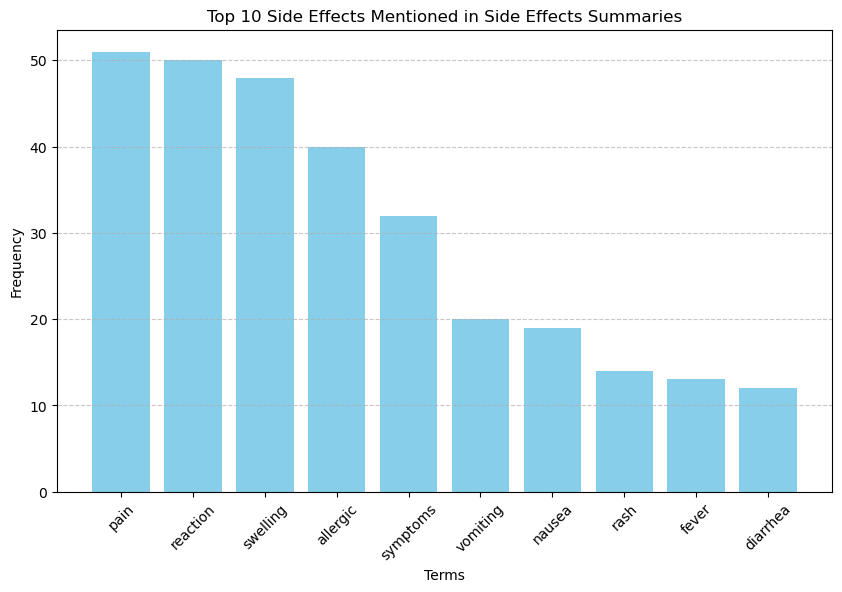

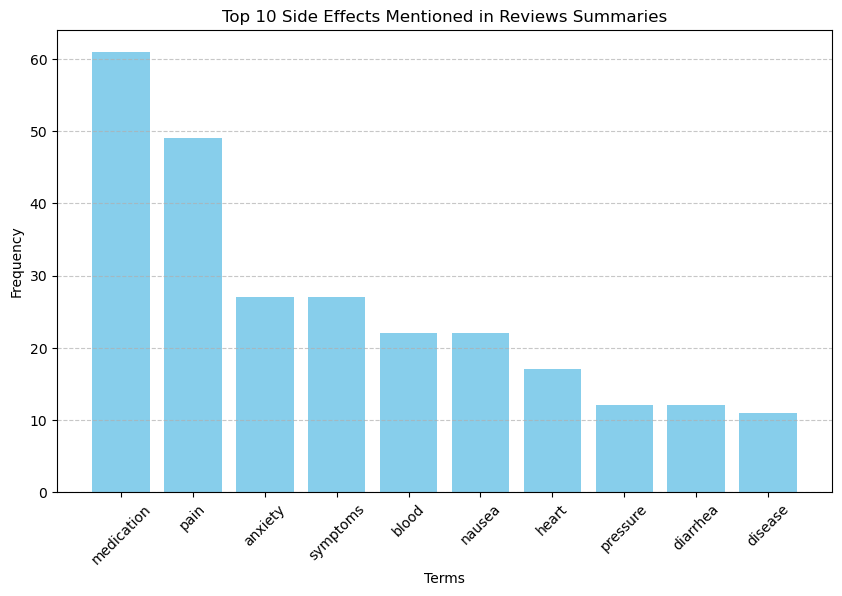

In [19]:


# Function to count frequency of terms
def count_terms(data):
    term_freq = Counter()
    for item in data:
        terms = item.split(", ")
        term_freq.update(terms)
    return term_freq

side_effects_freq = count_terms(df['side_effects_summary'])
reviews_freq = count_terms(df['reviews_summary'])

top_side_effects = side_effects_freq.most_common(10)
top_reviews = reviews_freq.most_common(10)


def plot_top_terms(top_terms, title):
    terms, counts = zip(*top_terms)  # unpacking the terms and counts
    plt.figure(figsize=(10, 6))
    plt.bar(terms, counts, color='skyblue')
    plt.xlabel('Terms')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_top_terms(top_side_effects, "Top 10 Side Effects Mentioned in Side Effects Summaries")
plot_top_terms(top_reviews, "Top 10 Side Effects Mentioned in Reviews Summaries")


## Model Summary

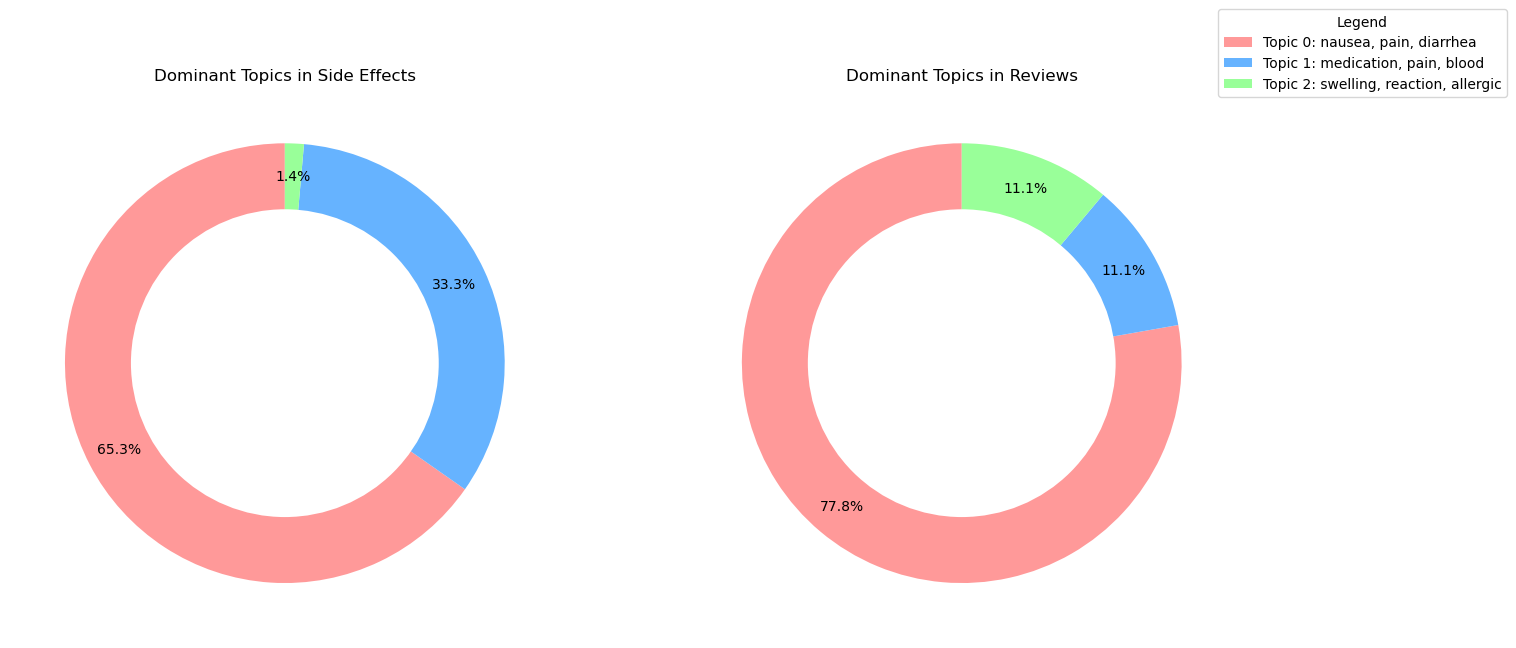

In [20]:
topic_side_effects_counts = df['dominant_topic_side_effects'].value_counts()
topic_reviews_counts = df['dominant_topic_reviews'].value_counts()

# Function to plot both pie charts in one figure with black percentage text and no labels on the donuts
def plot_combined_pie_charts_final(counts1, counts2, title1, title2, labels, legend_labels):
    colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']  # Colors for the pie chart
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # Creating a subplot for each pie chart

    # Pie chart for Side Effects
    wedges1, texts1, autotexts1 = axs[0].pie(counts1, labels=None, autopct='%1.1f%%', startangle=90, colors=colors,
                                             pctdistance=0.85, textprops=dict(color="black"))
    centre_circle1 = plt.Circle((0,0),0.70,fc='white')
    axs[0].add_artist(centre_circle1)
    axs[0].set_aspect('equal')
    axs[0].set_title(title1)

    # Pie chart for Reviews
    wedges2, texts2, autotexts2 = axs[1].pie(counts2, labels=None, autopct='%1.1f%%', startangle=90, colors=colors,
                                             pctdistance=0.85, textprops=dict(color="black"))
    centre_circle2 = plt.Circle((0,0),0.70,fc='white')
    axs[1].add_artist(centre_circle2)
    axs[1].set_aspect('equal')
    axs[1].set_title(title2)


    fig.legend(wedges1, legend_labels, title="Legend", loc="center left", bbox_to_anchor=(0.92, 0.5, 0.5, 1))
    plt.tight_layout()
    plt.show()


simplified_labels = ['Topic 0', 'Topic 1', 'Topic 2']

full_legend_labels = ['Topic 0: nausea, pain, diarrhea',
                      'Topic 1: medication, pain, blood',
                      'Topic 2: swelling, reaction, allergic']

plot_combined_pie_charts_final(topic_side_effects_counts, topic_reviews_counts, 
                               "Dominant Topics in Side Effects", "Dominant Topics in Reviews", 
                               simplified_labels, full_legend_labels)




In [21]:

text_data_side_effects = df['side_effects_summary'].dropna().astype(str)
text_data_reviews = df['reviews_summary'].dropna().astype(str)


# Function to vectorize text and perform clustering with PCA for faster execution
def vectorize_and_cluster_fast(text_data, num_clusters=3):
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(text_data)
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(X)
    pca = PCA(n_components=2)  # Using PCA instead of t-SNE
    X_reduced = pca.fit_transform(X.toarray())
    return X_reduced, labels

X_reduced_side_effects_fast, labels_side_effects_fast = vectorize_and_cluster_fast(text_data_side_effects)
X_reduced_reviews_fast, labels_reviews_fast = vectorize_and_cluster_fast(text_data_reviews)

def plot_clusters_adjusted_viridis(X_reduced, labels, title):
    fig, ax = plt.subplots(figsize=(10, 8))  
    unique_labels = np.unique(labels)
    # Adjusting viridis palette to be brighter for better visibility
    colors = [plt.cm.viridis(each) for each in np.linspace(0.2, 0.8, len(unique_labels))]  # Adjusting range for better brightness
    for k, col in zip(unique_labels, colors):
        class_member_mask = (labels == k)
        xy = X_reduced[class_member_mask]
        ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=8, alpha=0.6)
    colorbar = plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.viridis), ax=ax, label='Cluster Label')  # Pass the Axes object to colorbar
    ax.set_title(title)
    ax.set_xlabel("Topic Dimension 1")
    ax.set_ylabel("Topic Dimension 2")
    ax.grid(True)
    plt.show()


plot_clusters_adjusted_viridis(X_reduced_side_effects_fast, labels_side_effects_fast, "Cluster Map of Side Effects Topics")
plot_clusters_adjusted_viridis(X_reduced_reviews_fast, labels_reviews_fast, "Cluster Map of Reviews Topics")



AttributeError: 'NoneType' object has no attribute 'split'